In [2]:
%%capture
!pip install pytorch-lightning
!pip install torchmetrics
!pip install tqdm

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/Colab Notebooks/code'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/code


In [3]:
import pandas as pd
import numpy as np
import os.path
from IPython.utils import io

import torch
from torch import nn
from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics.functional import accuracy

import seaborn as sns
from pylab import rcParams
from tqdm.auto import tqdm
import my_utils as mu
import project_utils as pu

In [10]:
task_label = {
    1:'Correctness_label',
    2:'SNRdB_label',
    3:'Semanticity_label'
    }

ls = ['S{}'.format(i) for i in range(1,26)]
col = ['Task{}'.format(i) for i in range(1,4)]
result = pd.DataFrame(index = ls, columns = col)

BATCH_SIZE = 20
N_EPOCHS = 30

In [ ]:
for subject_No in range(1,26):
    print("Subject No." + str(subject_No) + ":")
    path = 'X{}_trial.csv'.format(subject_No)
    Y = pd.read_csv('PhyAAt_Data/phyaat_dataset/Signals/S{0}/S{0}_Textscore.csv'.format(subject_No))
    # 1 数据处理
    if os.path.exists(path):
      X = pd.read_csv(path)
      Y = pu.preprocess_Y(subject_No)
    else:
      X, Y = pu.preprocess_XY(subject_No)
      X.to_csv('X{}_trial.csv'.format(subject_No),index = False)

    FEATURE_COLUMNS = X.columns[1:15].tolist()
  
    for target_task in range(1,4):
        print("Task:",target_task)
        target_label = task_label[target_task]

        # 2 trial，分成sequence
        X_trial = pu.Split_Interpolate(X,Y,target_label)
        
        train_sequences, test_sequences = train_test_split(X_trial, test_size = 0.25)

        # 3 Dataset DataModuel
        data_module = pu.PhyAAtDataModule(train_sequences, test_sequences, BATCH_SIZE)
        
        # 4 Net and Model
        model = pu.RNNmodel(
            num_features = len(FEATURE_COLUMNS),
            num_classes = len(Y[task_label[target_task]].unique())
        )
        
        # 5 Train
        earlystopping_callback = EarlyStopping(
            monitor = 'val_accuracy',
            mode = 'max',
            patience = 10
        )

        checkpoint_callback = ModelCheckpoint(
            # dirpath = 'lightning_logs/checkpoints',
            filename = '{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}' ,
            save_top_k = 1,
            verbose = True,
            monitor = 'val_accuracy',
            mode = "max"
        )


        callback_list = [checkpoint_callback, earlystopping_callback]
        # logger = TensorBoardLogger("lightning_logs", name = task_label[target_task])
        # logger = TensorBoardLogger("lightning_logs", name = "Correctness")

        trainer = pl.Trainer(
        #     logger=logger,
            callbacks=callback_list,
            max_epochs=N_EPOCHS,
            gpus=1
            # ,auto_lr_find=True
        )
        
     
        trainer.fit(model, data_module)
        
        result.at["S{}".format(subject_No), "Task{}".format(target_task)] = round(float(checkpoint_callback.best_model_score),2)
        # print(result)

In [ ]:
result

In [ ]:
result.to_csv('result_c10classes.csv', index = False)
result.plot.bar(subplots = True, figsize = (15, 10))

In [18]:
result.at['Avg_Acc'] = round(result.mean(axis = 0, skipna = True),2)

In [ ]:
result

In [4]:
result = pd.read_csv('result_c10classes.csv')
result.at['Avg_Acc'] = round(result.mean(axis = 0, skipna = True),2)
result

,Task1,Task2,Task3
0,0.33,0.14,0.61
1,0.22,0.19,0.61
2,0.22,0.28,0.58
3,0.28,0.28,0.67
4,0.19,0.22,0.64
5,0.17,0.17,0.53
6,0.36,0.19,0.56
7,0.25,0.36,0.61
8,0.25,0.22,0.58
9,0.56,0.11,0.64


In [5]:
x_ls = []
y_ls = []
for subject_No in range(1,26):
#     print("Subject No." + str(subject_No) + ":")
    
    X = pd.read_csv('X{}_trial.csv'.format(subject_No))
    Y = pd.read_csv('PhyAAt_Data/phyaat_dataset/Signals/S{0}/S{0}_Textscore.csv'.format(subject_No))
    x_ls.append(X)
    y_ls.append(Y)

All_Subject_Y = pd.concat(y_ls, axis = 0, ignore_index = True)
All_Subject_X_trial = pd.concat(x_ls, axis = 0, ignore_index = True)
# All_Subject_X_trial.to_csv('All_Subject_X_trial.csv',index = False)

trial_group = (All_Subject_X_trial['Trial_No'].shift() != All_Subject_X_trial['Trial_No']).cumsum()
All_Subject_X_trial['Trial_No'] = trial_group
All_Subject_Y['trial_No'] = range(1, len(All_Subject_Y)+1)

In [7]:
All_Subject_X_trial

,TimeStamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Label_N,Label_S,Label_T,Trial_No
0,00:08:59:5138,-3.905409,-4.109658,-4.673459,-5.036478,-0.106369,0.692527,-0.027531,-0.979479,0.136901,3.438352,0.438004,0.650590,-1.259408,0.202234,1000,1,0,1
1,00:08:59:5138,3.749025,-1.810159,-6.282009,-5.173270,1.564089,-1.630181,-3.110391,-2.137532,0.305303,-17.074219,0.626153,0.867540,-1.737493,3.312453,1000,1,0,1
2,00:08:59:5138,2.749431,-9.091007,-3.498157,-6.094919,-0.777821,-0.000082,-2.285026,-0.373486,0.266672,-6.965864,0.136116,0.672692,-0.884477,1.414003,1000,1,0,1
3,00:08:59:5138,1.440520,-8.586300,0.237696,-3.749245,-2.332494,2.979494,-0.699675,0.582150,0.082744,-0.989682,-0.383172,0.524728,0.203029,0.171912,1000,1,0,1
4,00:08:59:5138,-5.754131,-5.173485,0.426342,-4.766405,-0.316168,2.186925,-0.782084,-0.529503,0.168216,25.698606,0.023788,1.203898,0.526216,-0.287937,1000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7548799,00:45:22:2825,-2.528336,1.204994,0.361213,-1.638359,2.306012,-2.628055,-2.211519,-7.592009,-4.143432,0.456106,1.649961,2.694289,2.429634,-2.315237,-6,1,2,3597
7548800,00:45:22:2825,-0.820692,2.256546,6.809999,0.962896,6.890243,0.179893,-0.895112,5.423883,3.529612,-1.425580,2.151671,10.746881,2.475141,2.885417,-6,1,2,3597
7548801,00:45:22:2825,-1.466109,0.792294,0.553093,-0.874119,1.634583,-1.469612,-1.290087,-3.992155,-2.152167,0.169775,1.032881,2.067848,1.489561,-1.160206,-6,1,2,3597
7548802,00:45:22:2825,-2.371565,-1.268536,-8.248416,-3.456568,-5.760529,-3.787345,-1.843553,-17.229782,-10.140390,2.413313,-0.542468,-10.142935,0.100852,-6.848735,-6,1,2,3597


In [8]:
All_Subject_Y

,TimeStamp,CaseID,SNRdB,Semanticity,TotalW,CorrectWords,Correctness,trial_No
0,00:09:26:736,1001,1000,1,9,9.0,100.000000,1
1,00:09:58:336,4,3,1,9,4.0,44.444444,2
2,00:10:21:664,1000,1000,0,8,8.0,100.000000,3
3,00:10:32:806,-5,-6,1,12,0.0,0.000000,4
4,00:10:43:826,-6,-6,0,4,2.0,50.000000,5
...,...,...,...,...,...,...,...,...
3592,00:44:08:984,-6,-6,0,12,0.0,0.000000,3593
3593,00:44:23:771,0,0,0,5,1.0,20.000000,3594
3594,00:44:39:037,-6,-6,0,4,1.0,25.000000,3595
3595,00:45:03:076,6,6,0,9,7.0,77.777778,3596


In [8]:
X = All_Subject_X_trial
Y = pu.preprocess_Y2(All_Subject_Y)

In [9]:
Y

,TimeStamp,CaseID,SNRdB,Semanticity,TotalW,CorrectWords,Correctness,trial_No,Semanticity_str,SNRdB_str,Correctness_str,Correctness_label,SNRdB_label,Semanticity_label
0,00:09:26:736,1001,1000,1,9,9.0,100.000000,1,1,1000,9,9,3,1
1,00:09:58:336,4,3,1,9,4.0,44.444444,2,1,3,4,4,4,1
2,00:10:21:664,1000,1000,0,8,8.0,100.000000,3,0,1000,9,9,3,0
3,00:10:32:806,-5,-6,1,12,0.0,0.000000,4,1,-6,0,0,1,1
4,00:10:43:826,-6,-6,0,4,2.0,50.000000,5,0,-6,5,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,00:44:08:984,-6,-6,0,12,0.0,0.000000,3593,0,-6,0,0,1,0
3593,00:44:23:771,0,0,0,5,1.0,20.000000,3594,0,0,2,2,2,0
3594,00:44:39:037,-6,-6,0,4,1.0,25.000000,3595,0,-6,2,2,1,0
3595,00:45:03:076,6,6,0,9,7.0,77.777778,3596,0,6,7,7,5,0


In [9]:
BATCH_SIZE = 100
N_EPOCHS = 50
FEATURE_COLUMNS = X.columns[1:15].tolist()

task_label = {
    1:'Correctness_label',
    2:'SNRdB_label',
    3:'Semanticity_label'
    }

for target_task in range(3,4):
  print("Task:",target_task)
  target_label = task_label[target_task]

  # 2 trial，分成sequence
  X_trial = pu.Split_Interpolate(X,Y,target_label)
  
  train_sequences, test_sequences = train_test_split(X_trial, test_size = 0.2)

  # 3 Dataset DataModuel
  data_module = pu.PhyAAtDataModule(train_sequences, test_sequences, BATCH_SIZE)
  
  # 4 Net and Model
  model = pu.RNNmodel(
      num_features = len(FEATURE_COLUMNS),
      num_classes = len(Y[task_label[target_task]].unique())
  )
  
  # 5 Train
  earlystopping_callback = EarlyStopping(
      monitor = 'val_accuracy',
      mode = 'max',
      patience = 10
  )

  checkpoint_callback = ModelCheckpoint(
      # dirpath = 'lightning_logs/checkpoints',
      filename = '{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}' ,
      save_top_k = 1,
      verbose = True,
      monitor = 'val_accuracy',
      mode = "max"
  )


  callback_list = [checkpoint_callback, earlystopping_callback]
  # logger = TensorBoardLogger("lightning_logs", name = task_label[target_task])
  # logger = TensorBoardLogger("lightning_logs", name = "Correctness")

  trainer = pl.Trainer(
  #     logger=logger,
      callbacks=callback_list,
      max_epochs=N_EPOCHS,
      gpus=1
      # ,auto_lr_find=True
  )
  
  trainer.fit(model, data_module)
  
  result.at['All_Subject'] = round(float(checkpoint_callback.best_model_score),2)
  # print(result)

Task: 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | RNNnet           | 87.2 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
87.2 K    Trainable params
0         Non-trainable params
87.2 K    Total params
0.349     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 29: 'val_accuracy' reached 0.49306 (best 0.49306), saving model to '/content/gdrive/MyDrive/Colab Notebooks/code/lightning_logs/version_228/checkpoints/epoch=00-val_accuracy=0.49-val_loss=0.69.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 58: 'val_accuracy' reached 0.53611 (best 0.53611), saving model to '/content/gdrive/MyDrive/Colab Notebooks/code/lightning_logs/version_228/checkpoints/epoch=01-val_accuracy=0.54-val_loss=0.69.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 87: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 116: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 145: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 174: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 203: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 232: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 261: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 290: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 319: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 348: 'val_accuracy' was not in top 1


In [10]:
result

,Task1,Task2,Task3
0,0.33,0.14,0.61
1,0.22,0.19,0.61
2,0.22,0.28,0.58
3,0.28,0.28,0.67
4,0.19,0.22,0.64
5,0.17,0.17,0.53
6,0.36,0.19,0.56
7,0.25,0.36,0.61
8,0.25,0.22,0.58
9,0.56,0.11,0.64


In [13]:
result.iloc[26,0] = 0.33

In [14]:
result.iloc[26,1] = 0.24

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ba0c88fd0>,
      dtype=object)

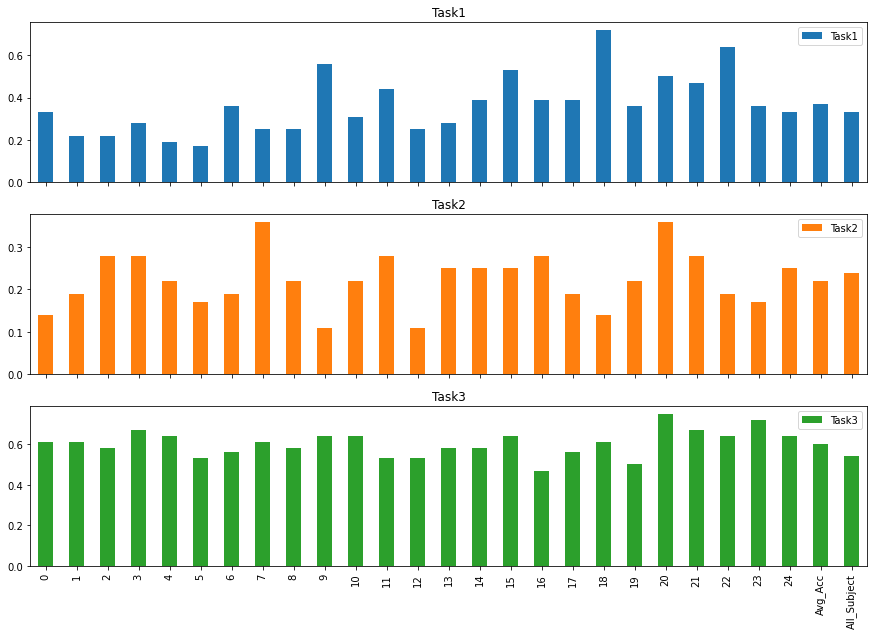

In [15]:
result.to_csv('result_c10classes_avg+all.csv')
result.plot.bar(subplots = True, figsize = (15, 10))

t1: 0.33
t2: 0.24
t3: 0.54